# UC-2 Binary Tune/Evaluate

Phase26.3 notebook with executed diagnostics outputs.

## Overview
- Purpose: Binary tuning and evaluation quick reference.
- API: `tune(config)`, `fit(config)`, `evaluate(artifact, data)`
- Outputs: metrics.csv, ROC/lift png, binary_scores.csv

## Learn More
Detailed tutorial: `notebooks/tutorials/tutorial_02_binary_classification_tuning.ipynb`

## Setup

In [1]:
from __future__ import annotations

import json
from datetime import datetime, timezone
from pathlib import Path

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display

from veldra.api import estimate_dr, evaluate, fit, tune
from veldra.api.artifact import Artifact
from veldra.diagnostics import (
    binary_metrics,
    build_binary_table,
    build_dr_table,
    build_drdid_table,
    build_frontier_table,
    build_multiclass_table,
    build_regression_table,
    compute_balance_smd,
    compute_importance,
    compute_overlap_stats,
    compute_shap,
    compute_shap_multiclass,
    frontier_metrics,
    multiclass_metrics,
    plot_error_histogram,
    plot_feature_importance,
    plot_frontier_scatter,
    plot_if_distribution,
    plot_lift_chart,
    plot_love_plot,
    plot_nll_histogram,
    plot_parallel_trends,
    plot_pinball_histogram,
    plot_propensity_distribution,
    plot_roc_comparison,
    plot_shap_summary,
    plot_timeseries_prediction,
    plot_timeseries_residual,
    plot_true_class_prob_histogram,
    plot_weight_distribution,
    regression_metrics,
)

ROOT = Path('.').resolve()
OUT_DIR = ROOT / 'examples' / 'out' / 'phase26_2_uc02_binary_tune_evaluate'
OUT_DIR.mkdir(parents=True, exist_ok=True)
diag_dir = OUT_DIR / 'diagnostics'
diag_dir.mkdir(parents=True, exist_ok=True)
UC_ID = 'UC-2'


/home/rem/repos/VeldraML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config Notes
- Keep compatibility output directories under `examples/out/phase26_*`.
- Keep key tuning knobs annotated with inline comments when modifying config payloads.

## Workflow

### Output Annotation
The following workflow cells materialize plots/tables consumed by evidence tests.

[I 2026-02-20 01:08:39,116] Using an existing study with name 'binary_tune_5e104a9f6bf0' instead of creating a new one.


[I 2026-02-20 01:08:39,916] Trial 3 finished with value: 0.07691990703302007 and parameters: {'learning_rate': 0.023688639503640783, 'train.num_leaves_ratio': 0.9753571532049581, 'train.early_stopping_validation_fraction': 0.24639878836228102, 'max_bin': 204, 'train.min_data_in_leaf_ratio': 0.02404167763981929, 'train.min_data_in_bin_ratio': 0.02403950683025824, 'max_depth': 3, 'feature_fraction': 0.9330880728874675, 'lambda_l2': 0.060111900059309144}. Best is trial 1 with value: 0.03989811120647069.


[I 2026-02-20 01:08:41,107] Trial 4 finished with value: 0.03989811120647069 and parameters: {'learning_rate': 0.051059032093947576, 'train.num_leaves_ratio': 0.5102922471479012, 'train.early_stopping_validation_fraction': 0.2939819704323988, 'max_bin': 234, 'train.min_data_in_leaf_ratio': 0.029110519961044856, 'train.min_data_in_bin_ratio': 0.02636424704863906, 'max_depth': 5, 'feature_fraction': 0.6521211214797689, 'lambda_l2': 0.05247611840679216}. Best is trial 1 with value: 0.03989811120647069.


[I 2026-02-20 01:08:42,011] Trial 5 finished with value: 0.08244989731571375 and parameters: {'learning_rate': 0.027036160666620016, 'train.num_leaves_ratio': 0.645614570099021, 'train.early_stopping_validation_fraction': 0.22237057894447587, 'max_bin': 144, 'train.min_data_in_leaf_ratio': 0.03629301836816964, 'train.min_data_in_bin_ratio': 0.04297256589643226, 'max_depth': 8, 'feature_fraction': 0.8925879806965068, 'lambda_l2': 0.019968178542053818}. Best is trial 1 with value: 0.03989811120647069.


,label,auc,logloss,brier,average_precision,accuracy,f1
0,in_sample,0.999788,0.070032,0.009664,0.999874,0.990610,0.992509
1,out_of_sample,0.988679,0.160309,0.038112,0.992722,0.958042,0.967033


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,y_true,fold_id,in_out_label,score
0,19.89,20.26,130.50,1214.0,0.10370,0.13100,0.14110,0.09431,0.1802,0.06188,...,0.14170,0.33090,0.4185,0.16130,0.2549,0.09136,0,0,in_sample,0.056853
1,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,0.05581,...,0.09616,0.11470,0.1186,0.05366,0.2309,0.06915,1,0,in_sample,0.959091
2,17.14,16.40,116.00,912.7,0.11860,0.22760,0.22290,0.14010,0.3040,0.07413,...,0.15450,0.39490,0.3853,0.25500,0.4066,0.10590,0,0,in_sample,0.056857
3,17.30,17.08,113.00,928.2,0.10080,0.10410,0.12660,0.08353,0.1813,0.05613,...,0.14160,0.24050,0.3378,0.18570,0.3138,0.08113,0,0,in_sample,0.056852
4,22.01,21.90,147.20,1482.0,0.10630,0.19540,0.24480,0.15010,0.1824,0.06140,...,0.12940,0.38850,0.4756,0.24320,0.2741,0.08574,0,0,in_sample,0.056852
5,16.69,20.20,107.10,857.6,0.07497,0.07112,0.03649,0.02307,0.1846,0.05325,...,0.10090,0.29200,0.2477,0.08737,0.4677,0.07623,0,0,in_sample,0.057082
6,11.90,14.65,78.11,432.8,0.11520,0.12960,0.03710,0.03003,0.1995,0.07839,...,0.14240,0.25170,0.0942,0.06042,0.2727,0.10360,1,0,in_sample,0.959089
7,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,0.16220,0.66560,0.7119,0.26540,0.4601,0.11890,0,0,in_sample,0.056908
8,17.20,24.52,114.20,929.4,0.10710,0.18300,0.16920,0.07944,0.1927,0.06487,...,0.15850,0.73940,0.6566,0.18990,0.3313,0.13390,0,0,in_sample,0.056851
9,9.72,18.22,60.73,288.1,0.06950,0.02344,0.00000,0.00000,0.1653,0.06447,...,0.07117,0.02729,0.0000,0.00000,0.1909,0.06559,1,0,in_sample,0.958412


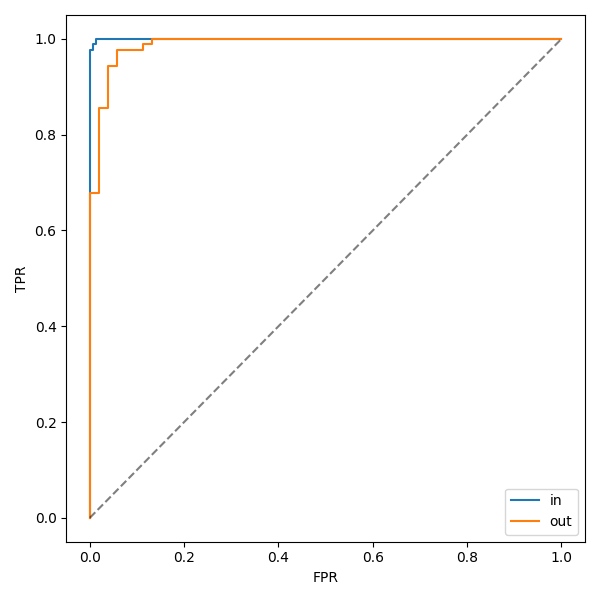

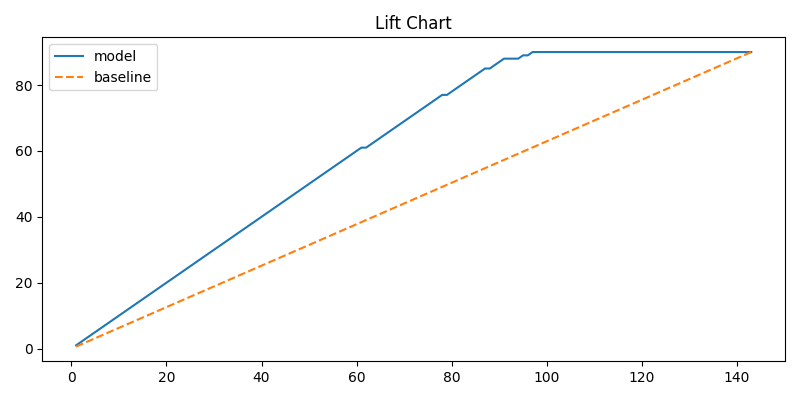

In [2]:
from sklearn.model_selection import train_test_split

source_df = pd.read_csv(ROOT / 'examples' / 'data' / 'breast_cancer_binary.csv')
train_df, test_df = train_test_split(
    source_df,
    test_size=0.25,
    random_state=42,
    stratify=source_df['target'],
)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_path = OUT_DIR / 'train.csv'
test_path = OUT_DIR / 'test.csv'
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

base_config = {
    'config_version': 1,
    'task': {'type': 'binary'},
    'data': {'path': str(train_path), 'target': 'target'},
    'split': {'type': 'stratified', 'n_splits': 4, 'seed': 42},
    'train': {
        'seed': 42,
        'num_boost_round': 2000,
        'early_stopping_rounds': 200,
        'early_stopping_validation_fraction': 0.2,
        'auto_num_leaves': True,
        'num_leaves_ratio': 1.0,
        'min_data_in_leaf_ratio': 0.01,
        'min_data_in_bin_ratio': 0.01,
        'metrics': ['logloss', 'auc'],
        'lgb_params': {
            'learning_rate': 0.01,
            'max_bin': 255,
            'max_depth': 10,
            'feature_fraction': 1.0,
            'bagging_fraction': 1.0,
            'bagging_freq': 0,
            'lambda_l1': 0.0,
            'lambda_l2': 0.000001,
            'min_child_samples': 20,
            'first_metric_only': True,
        },
    },
    'postprocess': {'calibration': 'platt'},
    'export': {'artifact_dir': str(OUT_DIR / 'artifacts_fit')},
}

tune_config = json.loads(json.dumps(base_config))
tune_config['tuning'] = {
    'enabled': True,
    'n_trials': 3,
    'resume': True,
    'objective': 'brier',
    'metrics_candidates': ['logloss', 'auc'],
    'search_space': {
        'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.1, 'log': True},
        'train.num_leaves_ratio': {'type': 'float', 'low': 0.5, 'high': 1.0},
        'train.early_stopping_validation_fraction': {'type': 'float', 'low': 0.1, 'high': 0.3},
        'max_bin': {'type': 'int', 'low': 127, 'high': 255},
        'train.min_data_in_leaf_ratio': {'type': 'float', 'low': 0.01, 'high': 0.1},
        'train.min_data_in_bin_ratio': {'type': 'float', 'low': 0.01, 'high': 0.1},
        'max_depth': {'type': 'int', 'low': 3, 'high': 15},
        'feature_fraction': {'type': 'float', 'low': 0.5, 'high': 1.0},
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'lambda_l1': 0.0,
        'lambda_l2': {'type': 'float', 'low': 0.000001, 'high': 0.1},
    },
}

tune_result = tune(tune_config)
fit_config = json.loads(json.dumps(base_config))
for key, value in tune_result.best_params.items():
    if key.startswith('train.'):
        fit_config['train'][key.split('.', 1)[1]] = value
    else:
        fit_config['train'].setdefault('lgb_params', {})[key] = value

run_result = fit(fit_config)
artifact = Artifact.load(run_result.artifact_path)
eval_result = evaluate(artifact, test_df)

x_train = train_df.drop(columns=['target'])
y_train = train_df['target'].to_numpy(dtype=int)
x_test = test_df.drop(columns=['target'])
y_test = test_df['target'].to_numpy(dtype=int)
pred_train = artifact.predict(x_train)
pred_test = artifact.predict(x_test)

score_train = pred_train['p_cal'].to_numpy(dtype=float)
score_test = pred_test['p_cal'].to_numpy(dtype=float)
metrics_df = pd.DataFrame(
    [
        binary_metrics(y_train, score_train, label='in_sample'),
        binary_metrics(y_test, score_test, label='out_of_sample'),
    ]
)
metrics_path = OUT_DIR / 'metrics.csv'
metrics_df.to_csv(metrics_path, index=False)

roc_path = diag_dir / 'roc_in_out.png'
plot_roc_comparison(y_train, score_train, y_test, score_test, roc_path)
lift_path = diag_dir / 'lift.png'
plot_lift_chart(y_test, score_test, lift_path)

booster = artifact._get_booster()
importance_df = compute_importance(booster, importance_type='gain', top_n=20)
importance_path = diag_dir / 'importance_gain.png'
plot_feature_importance(importance_df, 'gain', importance_path)
importance_df.to_csv(OUT_DIR / 'importance_gain.csv', index=False)

shap_frame = compute_shap(booster, x_train.head(min(len(x_train), 64)))
shap_path = diag_dir / 'shap_summary.png'
plot_shap_summary(shap_frame, x_train.head(min(len(x_train), 64)), shap_path)

score_table = build_binary_table(
    pd.concat([x_train, x_test], ignore_index=True),
    np.concatenate([y_train, y_test]),
    np.concatenate([
        np.zeros(len(x_train), dtype=int),
        np.ones(len(x_test), dtype=int),
    ]),
    np.concatenate([score_train, score_test]),
    ['in_sample'] * len(x_train) + ['out_of_sample'] * len(x_test),
)
score_path = OUT_DIR / 'binary_scores.csv'
score_table.to_csv(score_path, index=False)

display(metrics_df)
display(score_table.head(10))
display(Image(filename=str(roc_path)))
display(Image(filename=str(lift_path)))
display(Image(filename=str(importance_path)))
display(Image(filename=str(shap_path)))

summary_outputs = [
    train_path,
    test_path,
    metrics_path,
    roc_path,
    lift_path,
    importance_path,
    shap_path,
    score_path,
]
artifact_path_for_summary = run_result.artifact_path


## Result Summary

In [3]:
SUMMARY = {
    "uc": UC_ID,
    "executed_at_utc": datetime.now(timezone.utc).isoformat(),
    "status": "passed",
    "artifact_path": str(artifact_path_for_summary),
    "outputs": [str(p) for p in summary_outputs],
    "metrics": metrics_df.round(6).to_dict(orient="records"),
}
(OUT_DIR / "summary.json").write_text(json.dumps(SUMMARY, indent=2), encoding="utf-8")
SUMMARY


{'uc': 'UC-2',
 'executed_at_utc': '2026-02-19T16:08:43.260234+00:00',
 'status': 'passed',
 'artifact_path': '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/artifacts_fit/e75906402ff1434e8c81e0bb137ac83b',
 'outputs': ['/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/train.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/test.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/metrics.csv',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/diagnostics/roc_in_out.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/diagnostics/lift.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/diagnostics/importance_gain.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary_tune_evaluate/diagnostics/shap_summary.png',
  '/home/rem/repos/VeldraML/examples/out/phase26_2_uc02_binary